## Optical flow & object tracking

In [12]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

### Find features


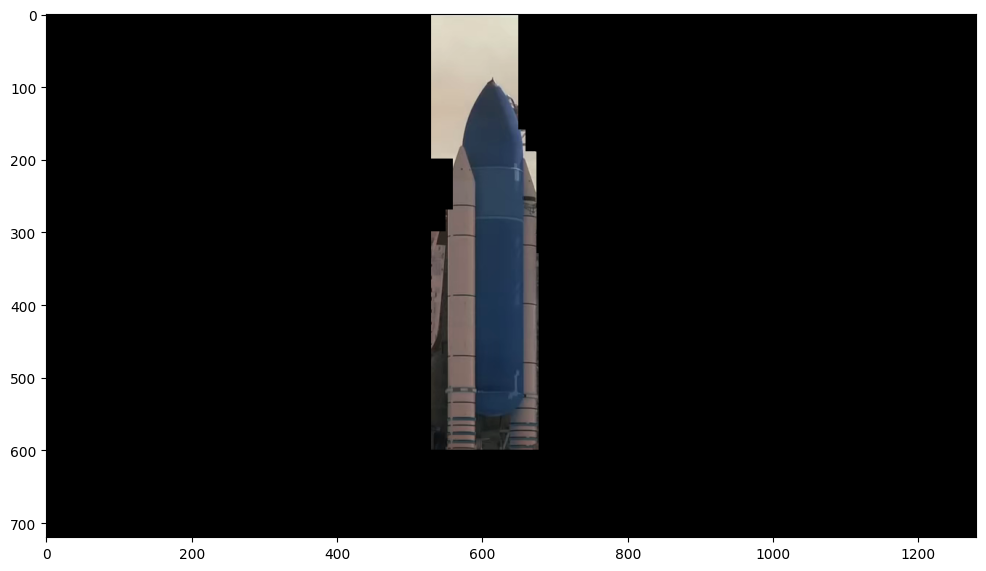

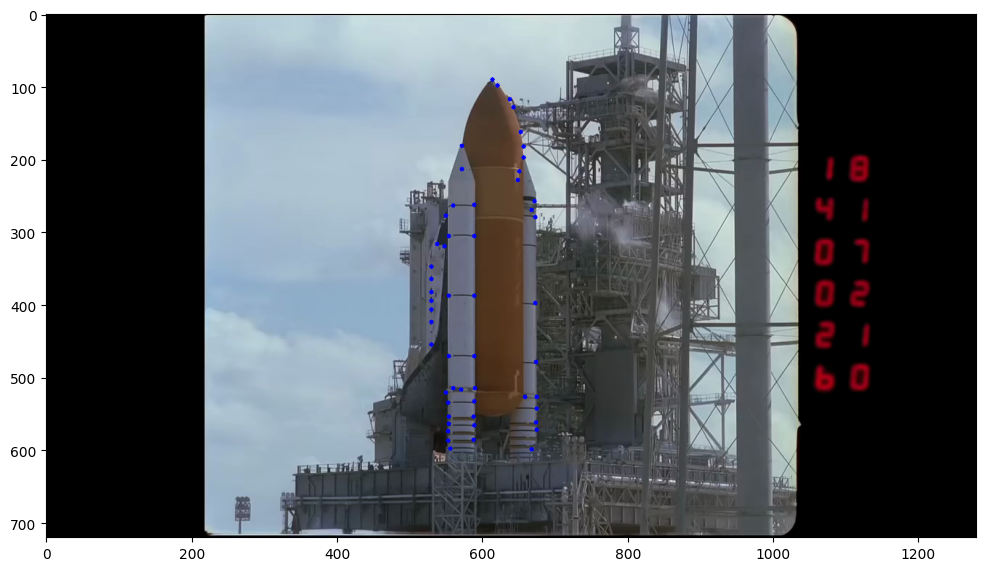

In [2]:
import cv2
import matplotlib.pyplot as plt

# Wczytaj pierwszą klatkę
source = cv2.VideoCapture('shuttle.mp4')
status, frame = source.read()

# Zwalnia źródło wideo
source.release()
mask = np.zeros_like(frame)
mask = mask[:,:,0]


mask[0:600, 530:678] = 255
mask[200:300, 530:550] = 0
mask[200:270, 530:560] = 0
mask[0:330, 675:678] = 0
mask[0:160, 650:678] = 0
mask[0:190, 660:678] = 0# Ustaw obszar na wartość 255 (biały)
#mask = cv2.convertScaleAbs(mask)
# Zastosuj maskę na obrazie

masked_img = cv2.bitwise_and(frame, frame, mask=mask)
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(masked_img)
plt.show()
# Konwertuj klatkę na odcienie szarości
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Ustawienia detektora cech
feature_params = dict(
    maxCorners=100,   # Maksymalna liczba cech do wykrycia
    qualityLevel=0.1,  # Poziom jakości cech (0-1)
    minDistance=10,
    #useHarrisDetector=True
)

# Wykryj cechy za pomocą cv2.goodFeaturesToTrack
corners = cv2.goodFeaturesToTrack(gray_frame, mask=mask, **feature_params)

# Narysuj detektowane cechy na klatce
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(frame, (int(x), int(y)), 3, 255, -1)

# Wyświetl klatkę z zaznaczonymi cechami
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])
plt.show()


### Optical flow


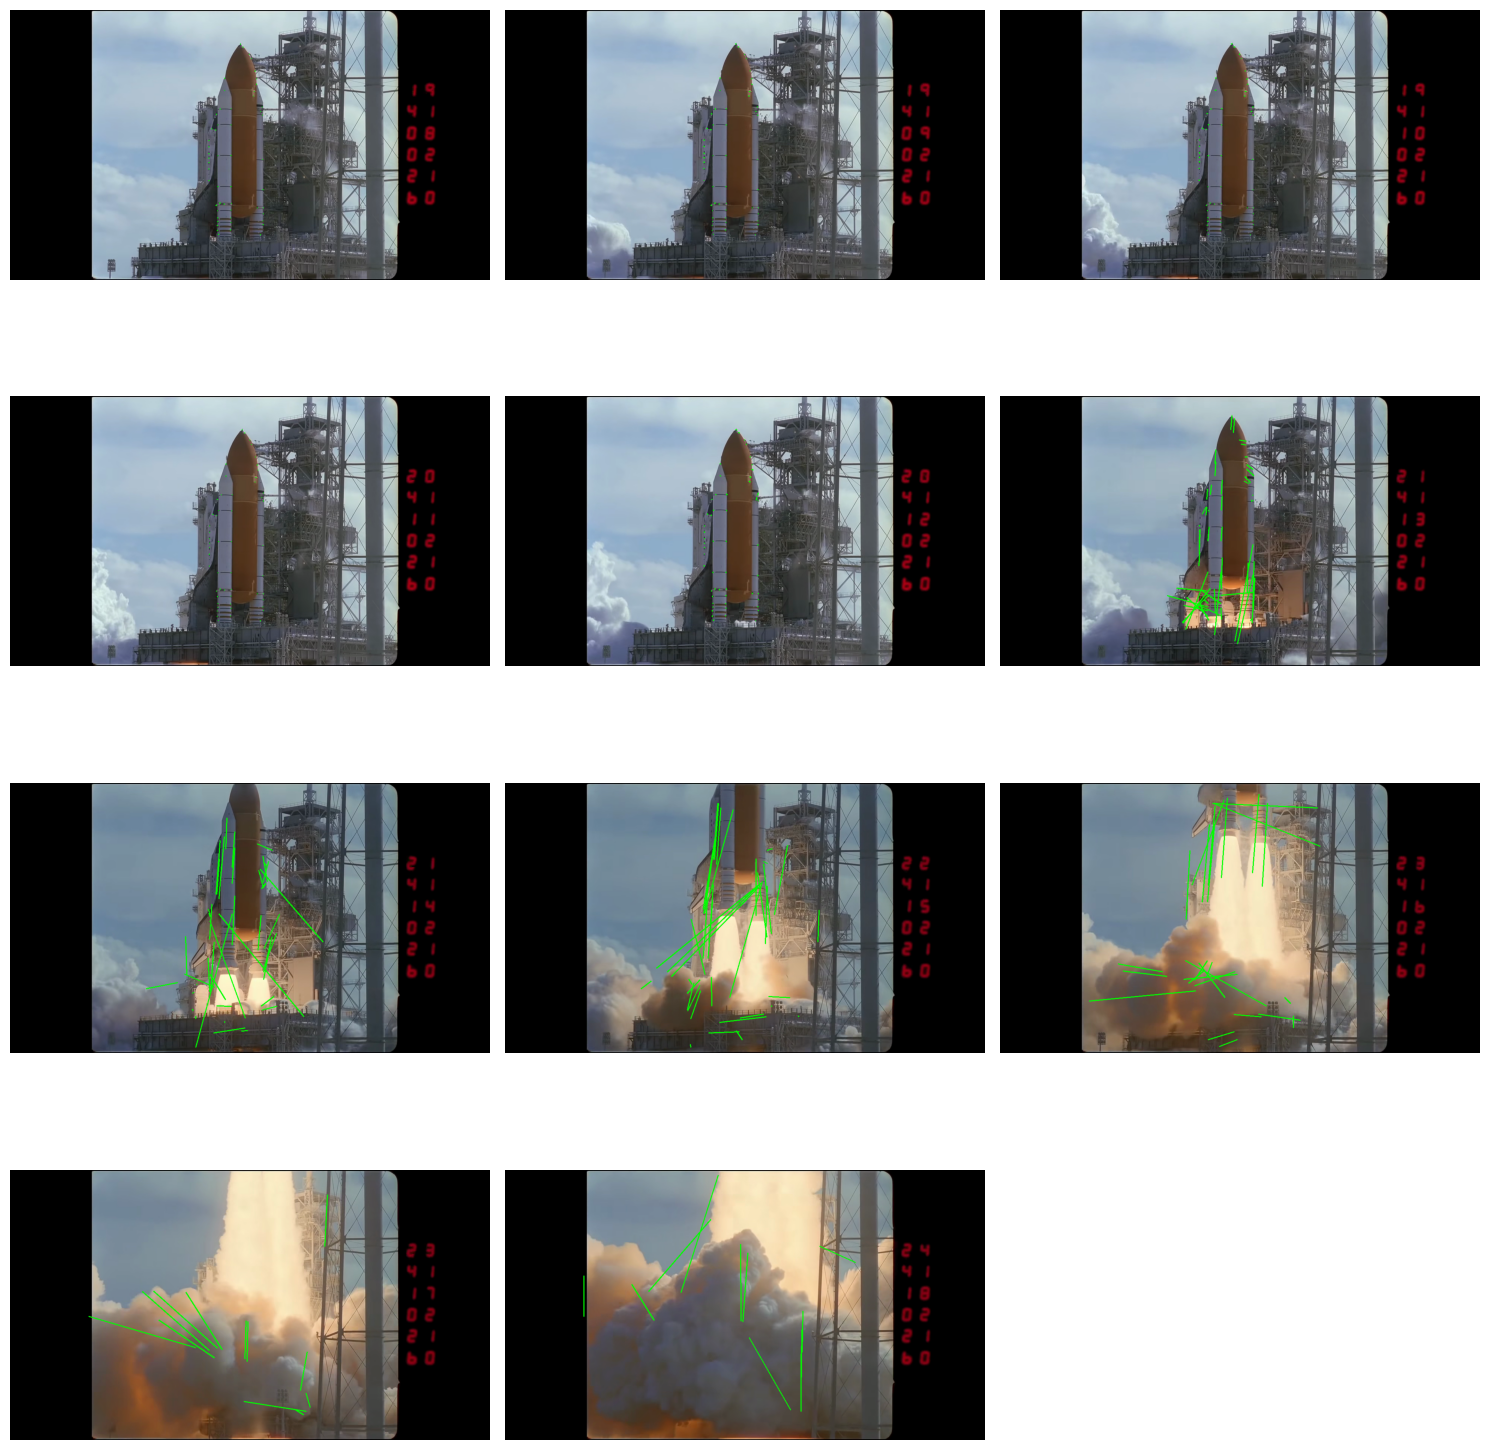

In [13]:
def get_init_corners(video_path):
    source = cv2.VideoCapture(video_path)  # Zmień na odpowiednią ścieżkę do filmu

    status, frame = source.read()
    source.release()
    mask = np.zeros_like(frame)
    mask = mask[:,:,0]


    mask[0:600, 530:678] = 255
    mask[200:300, 530:550] = 0
    mask[200:270, 530:560] = 0
    mask[0:330, 675:678] = 0
    mask[0:160, 650:678] = 0
    mask[0:190, 660:678] = 0# Ustaw obszar na wartość 255 (biały)
    #mask = cv2.convertScaleAbs(mask)
    # Zastosuj maskę na obrazie

    masked_img = cv2.bitwise_and(frame, frame, mask=mask)
    #plt.subplots(1, 1, figsize=(12, 12))[1].imshow(masked_img)
    #plt.show()
    # Konwertuj klatkę na odcienie szarości
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Ustawienia detektora cech
    feature_params = dict(
        maxCorners=100,   # Maksymalna liczba cech do wykrycia
        qualityLevel=0.1,  # Poziom jakości cech (0-1)
        minDistance=10,
        #useHarrisDetector=True
    )
    return cv2.goodFeaturesToTrack(gray_frame, mask=mask, **feature_params)


def baseLoop(video_path: str, step: int = 30, cols: int = 3):
    """Process a video and display trajectories in a grid of frames.

    Args:
        video_path: Path to the input video.
        step: Number of frames to skip between calculations.
        cols: Number of columns in the output grid (default is 3).
    """
    # Initialise
    init_points = get_init_corners(video_path)
    prev_pts = np.array(init_points, dtype=np.float32).reshape(-1, 1, 2)
    source = cv2.VideoCapture(video_path)
    fps = source.get(cv2.CAP_PROP_FPS)

    frames_to_show = []  # store processed frames for grid display

    source_status, frame2 = source.read()
    while source_status:
        # save the previous frame and skip ahead
        frame1 = frame2
        for _ in range(step):
            source_status, frame2 = source.read()
            if not source_status:
                break
        if not source_status:
            break

        # Convert to grayscale for optical flow
        frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Optical flow
        next_pts, status, _ = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, prev_pts, None)

        # Build trajectories only for successfully tracked points
        trajectories = []
        for i, ok in enumerate(status):
            if ok:
                trajectories.append([tuple(prev_pts[i, 0]), tuple(next_pts[i, 0])])

        # Draw trajectories on a copy of the current frame
        frame2_lines = frame2.copy()
        for traj in trajectories:
            cv2.polylines(frame2_lines, [np.int32(traj)], isClosed=False, color=(0, 255, 0), thickness=2)

        # Append processed frame for later display
        frames_to_show.append(cv2.cvtColor(frame2_lines, cv2.COLOR_BGR2RGB))

        # Prepare for next iteration
        prev_pts = next_pts.reshape(-1, 1, 2)

    # Clean‑up
    source.release()
    cv2.destroyAllWindows()

    # Determine grid size
    total = len(frames_to_show)
    rows = math.ceil(total / cols)

    # Create the subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = np.array(axes).reshape(-1)  # flatten for easy indexing even if rows==1

    for idx, ax in enumerate(axes):
        if idx < total:
            ax.imshow(frames_to_show[idx])
            ax.axis("off")
        else:
            ax.remove()  # remove unused axis for cleaner look

    plt.tight_layout()
    plt.show()


# Example usage

baseLoop("shuttle.mp4")

### Speed

In [4]:
def calculate_vertical_displacement(prev_pts, next_pts):
    # Oblicz różnice między współrzędnymi punktów
    displacements = next_pts - prev_pts

    displacements = displacements.reshape(displacements.shape[0], -1)
    vertical_displacements = displacements[:, 1]

    """threshold_down = np.percentile(vertical_displacements, 25)
    threshold_up = np.percentile(vertical_displacements, 75)
    vertical_displacements = vertical_displacements[vertical_displacements > threshold_down]
    vertical_displacements = vertical_displacements[vertical_displacements < threshold_up]"""
    # Oblicz całkowite przesunięcie w pionie (suma wartości przesunięć w osi Y)
    if len(vertical_displacements) == 0:
        vertical_displacements = 0
    else:
        vertical_displacements = np.mean(vertical_displacements)

    return vertical_displacements

In [5]:
def get_traj(video_path):
    frame1 = None
    init_points = get_init_corners(video_path)
    prev_pts = np.array(init_points, dtype=np.float32).reshape(-1, 1, 2)
    source = cv2.VideoCapture(video_path)
    fps = source.get(cv2.CAP_PROP_FPS)
    status, frame2 = source.read()
    
    
    trajectories = [[] for _ in range(len(init_points))]
    source_status = True
    counter = 0
    vertical_displacements = []
    while source_status:
        frame1 = frame2
        for x in range(        1):
            source_status, frame2 = source.read()
        if not source_status:
            break
        frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Ustawienie punktów do śledzenia
        
        next_pts, status, _ = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, prev_pts, None)

        # Aktualizacja trajektorii
        trajectories = [[tuple(last_point[0])] for last_point in prev_pts]
        for i in range(len(trajectories)):
            if status[i]:
                trajectories[i].append(tuple(next_pts[i][0]))
        trajectories = [trajectory for trajectory in trajectories if len(trajectory) > 1]

        # Aktualizacja punktów charakterystycznych
        total_vertical_displacement = calculate_vertical_displacement(prev_pts, next_pts)
        vertical_displacements.append(total_vertical_displacement)
        counter += 1
        prev_pts = np.copy(next_pts)
        
    cv2.destroyAllWindows()
    source.release()
    return vertical_displacements, fps

    

vertical_displacements, fps = get_traj('shuttle.mp4')
vertical_displacements = [-x for x in vertical_displacements]

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def speed_plot(data, num_bins=10, start=140, stop=290):
    # Oblicz średnią wartość
    bin_size = len(data) // num_bins
    
    mean_value = np.mean(data) * bin_size
    mean_4s = np.mean(data[start:stop]) * bin_size
    print(mean_4s)
    print(mean_value)
    
    agg_data = [np.mean(data[bin_size * x:bin_size * (x + 1)]) * bin_size for x in range(num_bins - 1)]
    
    plt.plot([x + 1 for x in range(len(agg_data))], agg_data, label='Średnie przemieszczenie')
    #plt.bar([x+1 for x in range(len(agg_data))], agg_data, align='center')

    # Dodaj linie poziome dla średnich
    plt.axhline(mean_value, color='green', linestyle='dashed', linewidth=2, label='Średnia')
    plt.axhline(mean_4s, color='red', linestyle='dashed', linewidth=2, label='Średnia od startu')

    # Ustawienia osi
    plt.xlabel(f'Czas [{len(data)} klatek pogrupowanych po {num_bins}]')
    plt.ylabel('Średnie przemieszczenie w pikselach')
    plt.title(f'Wykres przemieszczenia w czasie')

    # Pokazanie wykresu
    plt.legend()
    plt.show()
    return agg_data


85.73427
35.40072


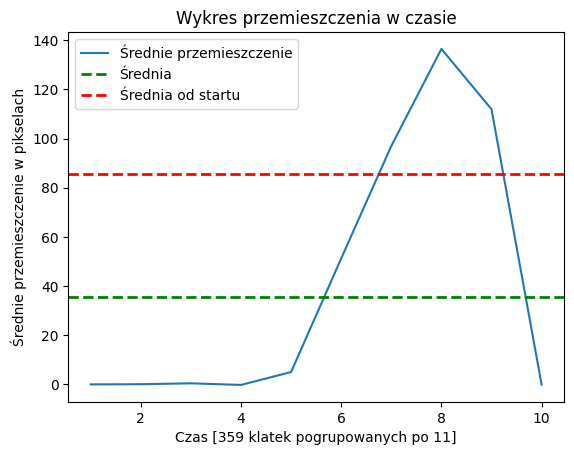

In [7]:
a = speed_plot(vertical_displacements, len(vertical_displacements)//int(fps))#, 14, 27)

2.679196
1.1062725


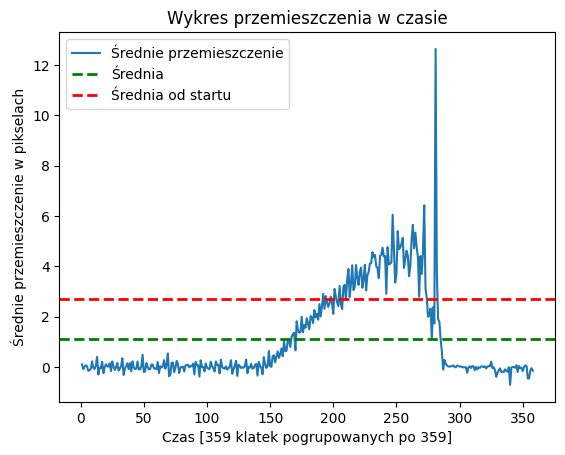

In [8]:
a = speed_plot(vertical_displacements, len(vertical_displacements))

In [9]:
# 11 cm, 340px, 38m
# 1m = 10.26px

g = 9.81
fps = 30
PIX_TO_M = 38/340
start_time, stop_time = 150, 240

move = a[start_time:stop_time]
time = stop_time - start_time # klatek
time = time / fps # sekund
move = [x * PIX_TO_M for x in move]
total_move = sum(move) # w metrach
mean_a = total_move * 2 / (time**2)

acc = [x * fps for x in move]

mean_twr = mean_a / g
print(mean_twr)

0.55144477


In [10]:
total_move

np.float32(24.343533)